In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from scipy import signal
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Load radar APS data
radar_APS = pd.read_csv("/content/gdrive/Shareddrives/ECE792-061/Dataset/data_final/rad_APS_norm.csv",header=None)
radar_APS = np.transpose(radar_APS.to_numpy())
print('Radar APS data shape:', radar_APS.shape)

Radar APS data shape: (3975, 64)


In [5]:
# Load communication APS data
comm_APS = pd.read_csv("/content/gdrive/Shareddrives/ECE792-061/Dataset/data_final/comm_APS_norm.csv",header = None)
comm_APS = np.transpose(comm_APS.to_numpy())
print('Communication APS data shape:', comm_APS.shape)

Communication APS data shape: (3975, 64)


In [6]:
# Split the data into training and test sets (0.8/0.2 ratio)
training_data, testing_data, training_label, testing_label = train_test_split(radar_APS, comm_APS, test_size=0.2, random_state=0)

print('Training shape:', training_data.shape)
print('Test shape:', testing_data.shape)

Training shape: (3180, 64)
Test shape: (795, 64)


In [7]:
# Increase the dimensions of the data for CNN architecture
training_data = training_data.reshape((training_data.shape[0], 64, 1))
training_label = training_label.reshape((training_label.shape[0], 64, 1))
testing_data = testing_data.reshape((testing_data.shape[0], 64, 1))
testing_label = testing_label.reshape((testing_label.shape[0], 64, 1))

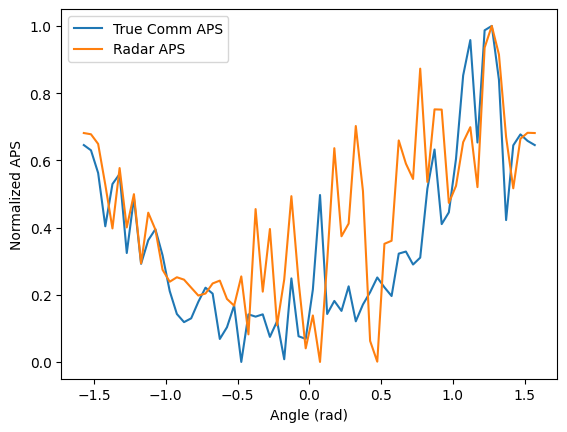

In [8]:
# Plot a sample APS
sample_ID = 125
x = np.linspace(-np.pi/2, np.pi/2, num=64)
sample_APS = plt.figure()
plt.plot(x, training_label[sample_ID][:, 0], label = "True Comm APS")
plt.plot(x, training_data[sample_ID][:, 0], label = "Radar APS")
plt.legend()
plt.xlabel('Angle (rad)')
plt.ylabel('Normalized APS')
plt.show()
sample_APS.savefig("sample_APS.eps", format='eps')

In [9]:
# We define the described CNN architecture
kernel_var = 5
def APSPred_m3():
  blk1 = keras.Sequential(
      [
        layers.Conv1D(8, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(8, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding="valid", data_format="channels_last")
      ]
  )
  blk2 = keras.Sequential(
      [
        layers.Conv1D(16, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(16, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(axis=-1)
      ]
  )

  blk3 = keras.Sequential(
      [
        layers.Conv1D(16, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(8, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        # tf.keras.layers.BatchNormalization(axis=-2)
      ]
  )
  UnPool = layers.UpSampling1D(size=2)
  blk4 = keras.Sequential(
      [
        layers.Conv1D(4, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(1, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        # tf.keras.layers.BatchNormalization(axis=-2)
      ]
       )
  blk5 = keras.Sequential(
      [   
          layers.Dense(128),
          layers.Dense(64, activation='sigmoid'),
      ]
  )
  inputs = keras.layers.Input(shape=(64, 1),dtype=tf.float64)
  x = blk1(inputs)
  x = blk2(x)
  x = blk3(x)
  x = UnPool(x)
  x = blk4(x)
  x = blk5(x)
  model3 = keras.Model(inputs, x, name='APSPred')
  return model3


  # The optimizer is selected as ADAM with learning rate 0.0001
opt = keras.optimizers.Adam(learning_rate=0.0001)
# Create the APSPred model
model3 = APSPred_m3()
# Compile the model with Mean Squared Error (MSE) loss function
model3.compile(optimizer=opt, loss=keras.losses.MeanSquaredError(), metrics=['accuracy'])
# Train the model for 1000 epoch with batch size 64
Model_3 = model3.fit(training_data, training_label, epochs=100, batch_size=64, verbose=2)

Epoch 1/100
50/50 - 15s - loss: 0.0763 - accuracy: 0.0140 - 15s/epoch - 310ms/step
Epoch 2/100
50/50 - 0s - loss: 0.0618 - accuracy: 0.0144 - 364ms/epoch - 7ms/step
Epoch 3/100
50/50 - 0s - loss: 0.0481 - accuracy: 0.0142 - 361ms/epoch - 7ms/step
Epoch 4/100
50/50 - 0s - loss: 0.0406 - accuracy: 0.0067 - 355ms/epoch - 7ms/step
Epoch 5/100
50/50 - 0s - loss: 0.0367 - accuracy: 0.0000e+00 - 353ms/epoch - 7ms/step
Epoch 6/100
50/50 - 0s - loss: 0.0344 - accuracy: 0.0000e+00 - 360ms/epoch - 7ms/step
Epoch 7/100
50/50 - 0s - loss: 0.0327 - accuracy: 0.0000e+00 - 363ms/epoch - 7ms/step
Epoch 8/100
50/50 - 0s - loss: 0.0314 - accuracy: 0.0000e+00 - 351ms/epoch - 7ms/step
Epoch 9/100
50/50 - 0s - loss: 0.0304 - accuracy: 0.0000e+00 - 355ms/epoch - 7ms/step
Epoch 10/100
50/50 - 0s - loss: 0.0296 - accuracy: 0.0000e+00 - 352ms/epoch - 7ms/step
Epoch 11/100
50/50 - 0s - loss: 0.0290 - accuracy: 0.0000e+00 - 354ms/epoch - 7ms/step
Epoch 12/100
50/50 - 0s - loss: 0.0284 - accuracy: 0.0000e+00 - 367

In [10]:
# We define the described CNN architecture
kernel_var = 5
def APSPred_m3_MaxPool():
  blk1 = keras.Sequential(
      [
        layers.Conv1D(8, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(8, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding="valid", data_format="channels_last")
      ]
  )
  blk2 = keras.Sequential(
      [
        layers.Conv1D(16, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(16, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding="valid", data_format="channels_last"),
        tf.keras.layers.BatchNormalization(axis=-1)
      ]
  )

  blk3 = keras.Sequential(
      [
        layers.Conv1D(16, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(8, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding="valid", data_format="channels_last")
        # tf.keras.layers.BatchNormalization(axis=-2)
      ]
  )
  UnPool = layers.UpSampling1D(size=2)
  blk4 = keras.Sequential(
      [
        layers.Conv1D(4, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.Conv1D(1, kernel_size = kernel_var, padding="same", activation=tf.keras.layers.LeakyReLU(), kernel_initializer='he_uniform'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding="valid", data_format="channels_last"),
        # tf.keras.layers.BatchNormalization(axis=-2)
      ]
       )
  blk5 = keras.Sequential(
      [   
          layers.Dense(128),
          layers.Dense(64, activation='sigmoid'),
      ]
  )
  inputs = keras.layers.Input(shape=(64, 1),dtype=tf.float64)
  x = blk1(inputs)
  x = blk2(x)
  x = blk3(x)
  x = blk4(x)
  x = UnPool(x)
  x = UnPool(x)
  x = UnPool(x)
  x = UnPool(x)
  x = blk5(x)
  model3_MaxPool = keras.Model(inputs, x, name='APSPred')
  return model3_MaxPool


  # The optimizer is selected as ADAM with learning rate 0.0001
opt = keras.optimizers.Adam(learning_rate=0.0001)
# Create the APSPred model
model3_MaxPool = APSPred_m3_MaxPool()
# Compile the model with Mean Squared Error (MSE) loss function
model3_MaxPool.compile(optimizer=opt, loss=keras.losses.MeanSquaredError(), metrics=['accuracy'])
# Train the model for 1000 epoch with batch size 64
Model_3_MaxPool = model3_MaxPool.fit(training_data, training_label, epochs=100, batch_size=64, verbose=2)

Epoch 1/100
50/50 - 5s - loss: 0.0784 - accuracy: 0.0000e+00 - 5s/epoch - 95ms/step
Epoch 2/100
50/50 - 1s - loss: 0.0719 - accuracy: 0.0000e+00 - 509ms/epoch - 10ms/step
Epoch 3/100
50/50 - 1s - loss: 0.0520 - accuracy: 0.0000e+00 - 602ms/epoch - 12ms/step
Epoch 4/100
50/50 - 1s - loss: 0.0411 - accuracy: 0.0000e+00 - 600ms/epoch - 12ms/step
Epoch 5/100
50/50 - 1s - loss: 0.0379 - accuracy: 0.0000e+00 - 593ms/epoch - 12ms/step
Epoch 6/100
50/50 - 1s - loss: 0.0365 - accuracy: 0.0000e+00 - 591ms/epoch - 12ms/step
Epoch 7/100
50/50 - 1s - loss: 0.0355 - accuracy: 0.0000e+00 - 650ms/epoch - 13ms/step
Epoch 8/100
50/50 - 0s - loss: 0.0346 - accuracy: 0.0000e+00 - 428ms/epoch - 9ms/step
Epoch 9/100
50/50 - 0s - loss: 0.0338 - accuracy: 0.0000e+00 - 416ms/epoch - 8ms/step
Epoch 10/100
50/50 - 0s - loss: 0.0332 - accuracy: 0.0000e+00 - 405ms/epoch - 8ms/step
Epoch 11/100
50/50 - 0s - loss: 0.0327 - accuracy: 0.0000e+00 - 401ms/epoch - 8ms/step
Epoch 12/100
50/50 - 0s - loss: 0.0323 - accurac

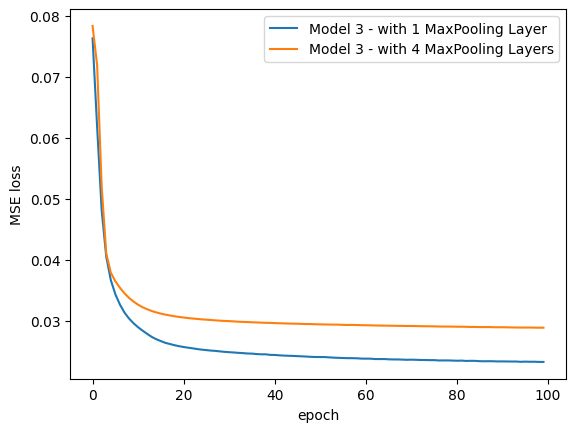

In [11]:
ModelComp = plt.figure()
plt.plot(Model_3.history['loss'][0:100])
plt.plot(Model_3_MaxPool.history['loss'][0:100])
#plt.title('model loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['Model 3 - with 1 MaxPooling Layer', 'Model 3 - with 4 MaxPooling Layers'], loc='upper right')
plt.show()

In [12]:
from google.colab import files
ModelComp.savefig('MSE_MaxPoolComp.eps', format='eps')
files.download('MSE_MaxPoolComp.eps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Predict the outputs for the testing data
predictions3 = model3.predict(testing_data)
# Predict the outputs for the testing data
predictions3_MaxPool = model3_MaxPool.predict(testing_data)


25/25 [==============================] - 0s 5ms/step


In [14]:
# Define the function for similarity metric
def cost_func(L, predict, test_label):
  
  cost = np.zeros((np.size(test_label[:, 0]),1))
  
  for i in range(0, np.size(test_label[:, 0])):
    max_idx = np.argsort(test_label[i][:, 0])
    max_idx = np.flip(max_idx)
    num = np.sum(predict[i][[max_idx[0:L]], 0])
    
    max_idx = np.argsort(predict[i][:, 0])
    max_idx = np.flip(max_idx)
    den = np.sum(predict[i][[max_idx[0:L]], 0])
    
    cost[i] = num/den
  return cost

In [15]:
# For Model 3 kernel = 3
# Calculate the similarity metric with L=5 maximum values for each prediction
sim_metric3 = cost_func(5, predictions3, testing_label)
print('Shape of the similarity metric:', sim_metric3.shape)
max_index = np.argsort(sim_metric3[:,0])
print('Minimum similarity metric in the test set:', np.min(sim_metric3))
print('Maximum similarity metric in the test set:', np.max(sim_metric3))
print('Average similarity metric in the test set:', np.mean(sim_metric3))

Shape of the similarity metric: (795, 1)
Minimum similarity metric in the test set: 0.3580191731452942
Maximum similarity metric in the test set: 1.0000001192092896
Average similarity metric in the test set: 0.8999654895479574


In [16]:
# For Model 3 kernel = 3
# Calculate the similarity metric with L=5 maximum values for each prediction
sim_metric3_MaxPool = cost_func(5, predictions3_MaxPool, testing_label)
print('Shape of the similarity metric:', sim_metric3.shape)
max_index = np.argsort(sim_metric3_MaxPool[:,0])
print('Minimum similarity metric in the test set:', np.min(sim_metric3_MaxPool))
print('Maximum similarity metric in the test set:', np.max(sim_metric3_MaxPool))
print('Average similarity metric in the test set:', np.mean(sim_metric3_MaxPool))

Shape of the similarity metric: (795, 1)
Minimum similarity metric in the test set: 0.329645037651062
Maximum similarity metric in the test set: 1.0
Average similarity metric in the test set: 0.9489642733298008


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

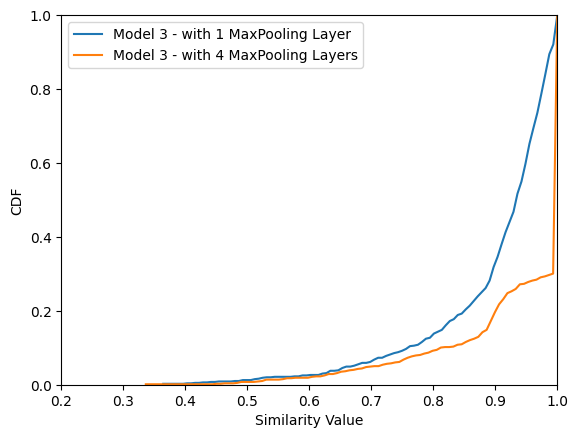

In [17]:
# Plot the CDF of the similarity value
count, bin_count = np.histogram(sim_metric3, bins=100)
pdf = count/sum(count)
cdf = np.cumsum(pdf)
CDF = plt.figure()

count3, bin_count3 = np.histogram(sim_metric3_MaxPool, bins=100)
pdf3 = count3/sum(count3)
cdf3 = np.cumsum(pdf3)
CDF3 = plt.figure()



CDF = plt.figure()
plt.plot(bin_count[1:], cdf, label='Model 3 - with 1 MaxPooling Layer')
plt.plot(bin_count3[1:], cdf3, label='Model 3 - with 4 MaxPooling Layers')

plt.xlim((0.2,1))
plt.ylim((0,1))
plt.xlabel('Similarity Value')
plt.ylabel('CDF')
plt.legend()
#CDF.savefig('CDF.eps', format='eps')

In [18]:
from google.colab import files
CDF.savefig('CDF_MaxPoolComp.eps', format='eps')
files.download('CDF_MaxPoolComp.eps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Similarity metric: 1.0


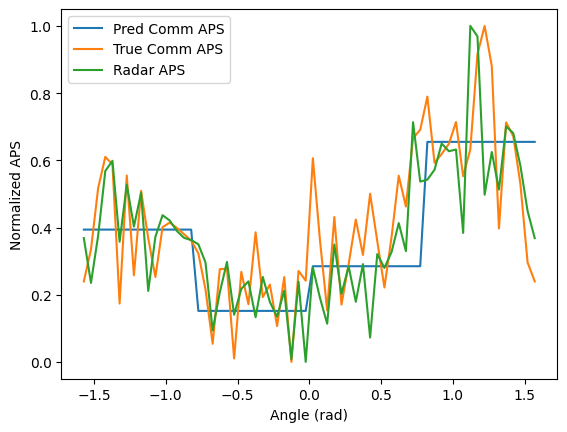

In [28]:
# Show the APS results of a good estimation case for model 3
sample_ID = np.random.randint(testing_data.shape[0])
print('Similarity metric:', sim_metric3_MaxPool[max_index[sample_ID]][0])
x = np.linspace(-np.pi/2, np.pi/2, num=64)
good_estimate = plt.figure()
plt.plot(x, predictions3_MaxPool[max_index[sample_ID]][:, 0], label = "Pred Comm APS")
plt.plot(x, testing_label[max_index[sample_ID]][:, 0], label = "True Comm APS")
plt.plot(x, testing_data[max_index[sample_ID]][:, 0], label = "Radar APS")
plt.xlabel('Angle (rad)')
plt.ylabel('Normalized APS')
plt.legend()
plt.show()
good_estimate.savefig('good_estimate.eps', format='eps')

In [31]:
from google.colab import files
good_estimate.savefig('good_estimate .eps', format='eps')
files.download('good_estimate .eps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>